In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# dataset.zip 압축 풀기
!unzip --qq /content/drive/MyDrive/aip_dataset.zip

In [5]:
# torch 관련 라이브러리
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR, CyclicLR, CosineAnnealingLR, ExponentialLR
from torchsummary import summary
# 일반 라이브러리
import argparse
import numpy as np
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


In [6]:
# 모델 학습 관련 파라미터 모음 --> 자유롭게 변경하고, 추가해보세요.

class Args():
  data_type = "2d"
  scheduler = "steplr"
  n_class = 10
  epoch = 50
  phase = "train"
  model_path = "./model_weight_2d.pth"

args = Args()

In [7]:
import torch
import torchaudio
from torch.utils.data import Dataset
import os

class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.classes = sorted(os.listdir(directory))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.samples = []


        for class_name in self.classes:
            class_dir = os.path.join(directory, class_name)
            for image_name in os.listdir(class_dir):
                self.samples.append((os.path.join(class_dir, image_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = models

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        output = sum(outputs) / len(outputs)
        return output

In [9]:
def get_model(name, n_class, pretrained=True):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        num_features = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_features, n_class)
    elif name == 'resnet':
        model = models.resnet18(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, n_class)
    elif name == 'resnet50':
        model = models.resnet50(pretrained=pretrained)
        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, n_class)
    return model

class Simple2DCNN(nn.Module):
    def __init__(self):
        super(Simple2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # 입력 채널 3, 출력 채널 64
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 입력 채널 64, 출력 채널 128
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # 입력 채널 128, 출력 채널 256
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # 입력 채널 256, 출력 채널 518
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # 입력 채널 256, 출력 채널 1036
        self.dropout = nn.Dropout(p=0.5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 2x2 풀링
        self.adaptive_pool = nn.AdaptiveAvgPool2d(7)
        self.fc = nn.Linear(1024 * 7 * 7, 6)  # 최종 출력을 위한 완전 연결 계층

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 컨볼루션 + 풀링
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 컨볼루션 + 풀링
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))  # 세 번째 컨볼루션 + 풀링
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))  # 네 번째 컨볼루션 + 풀링
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv5(x)))  # 다섯 번째 컨볼루션 + 풀링
        x = self.dropout(x)
        x = self.adaptive_pool(x)  # Adaptive Pooling 적용
        x = x.view(-1, 1024 * 7 * 7)  # 플래트닝
        x = self.fc(x)  # 완전 연결 계층
        return x

class hiinnnii(nn.Module):
    def __init__(self):
        super(hiinnnii, self).__init__()


In [10]:
# 학습 관련 모델
def train_model(model, train_loader, epochs, device, args):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    if args.scheduler == 'multistep':
        scheduler = MultiStepLR(optimizer, [5,10], gamma=0.3)
    elif args.scheduler == 'steplr':
        scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    elif args.scheduler == 'cosine':
        scheduler = CosineAnnealingLR(optimizer, T_max=epochs)
    elif args.scheduler == 'exponential':
        scheduler = ExponentialLR(optimizer, gamma=0.9)
    elif args.scheduler == 'cycliclr':
        scheduler = CyclicLR(optimizer, base_lr = 1e-5, max_lr = 1e-1, step_size_up = 5, mode = "triangular", cycle_momentum=False)


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)
        correct_predictions = 0
        total_samples = 0

        for i, (audio_signals, labels) in enumerate(tqdm(train_loader)):
            audio_signals, labels = audio_signals.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(audio_signals)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        avg_loss = running_loss / total_batches
        accuracy = correct_predictions / total_samples
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

        # 스케줄러 업데이트
        scheduler.step()

    print('Finished Training')

    # 모델 저장
    torch.save(model.state_dict(), f"./model_weight_{args.data_type}.pth")
    return model

In [11]:
if args.data_type == "2d":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),  # Moderate rotation
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Moderate color jitter
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.0)),  # Slightly random crop
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageDataset(directory='/content/train', transform=transform)
    train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=34)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
# Device 설정 --> gpu로 학습하기 위해서 런타임 유형 변경하세요.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(f"학습 데이터 수는 {len(train_dataset)}개 입니다.")
print(f"검증 데이터 수는 {len(val_dataset)}개 입니다.")

cuda
학습 데이터 수는 873개 입니다.
검증 데이터 수는 219개 입니다.


In [12]:
# ResNet18 모델 학습
args.model = 'resnet'
model_resnet = get_model(args.model, args.n_class, pretrained=True)
model_resnet = train_model(model_resnet, train_loader, epochs=args.epoch, device=device, args=args)
torch.save(model_resnet.state_dict(), './model_weight_resnet.pth')

# VGG16 모델 학습
args.model = 'vgg16'
model_vgg = get_model(args.model, args.n_class, pretrained=True)
model_vgg = train_model(model_vgg, train_loader, epochs=args.epoch, device=device, args=args)
torch.save(model_vgg.state_dict(), './model_weight_vgg.pth')

# Simple2DCNN 모델 학습
args.model = 'resnet50'
model_resnet50 = get_model(args.model, args.n_class, pretrained=True)
model_resnet50 = train_model(model_resnet50, train_loader, epochs=args.epoch, device=device, args=args)
torch.save(model_resnet50.state_dict(), './model_weight_resnet50.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]
  0%|          | 0/437 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIP

Epoch [1/50], Loss: 0.8268, Accuracy: 0.8076


100%|██████████| 437/437 [00:05<00:00, 76.42it/s]


Epoch [2/50], Loss: 0.3704, Accuracy: 0.9141


100%|██████████| 437/437 [00:05<00:00, 77.51it/s]


Epoch [3/50], Loss: 0.2836, Accuracy: 0.9404


100%|██████████| 437/437 [00:05<00:00, 77.72it/s]


Epoch [4/50], Loss: 0.2042, Accuracy: 0.9611


100%|██████████| 437/437 [00:05<00:00, 77.39it/s]


Epoch [5/50], Loss: 0.1761, Accuracy: 0.9622


100%|██████████| 437/437 [00:05<00:00, 77.46it/s]


Epoch [6/50], Loss: 0.1145, Accuracy: 0.9794


100%|██████████| 437/437 [00:05<00:00, 77.12it/s]


Epoch [7/50], Loss: 0.0749, Accuracy: 0.9897


100%|██████████| 437/437 [00:05<00:00, 77.26it/s]


Epoch [8/50], Loss: 0.0745, Accuracy: 0.9897


100%|██████████| 437/437 [00:05<00:00, 76.84it/s]


Epoch [9/50], Loss: 0.0579, Accuracy: 0.9920


100%|██████████| 437/437 [00:05<00:00, 77.51it/s]


Epoch [10/50], Loss: 0.0527, Accuracy: 0.9920


100%|██████████| 437/437 [00:05<00:00, 76.76it/s]


Epoch [11/50], Loss: 0.0430, Accuracy: 0.9966


100%|██████████| 437/437 [00:05<00:00, 77.91it/s]


Epoch [12/50], Loss: 0.0306, Accuracy: 0.9977


100%|██████████| 437/437 [00:05<00:00, 76.67it/s]


Epoch [13/50], Loss: 0.0290, Accuracy: 0.9989


100%|██████████| 437/437 [00:05<00:00, 77.64it/s]


Epoch [14/50], Loss: 0.0195, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.09it/s]


Epoch [15/50], Loss: 0.0202, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.61it/s]


Epoch [16/50], Loss: 0.0186, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.12it/s]


Epoch [17/50], Loss: 0.0176, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.34it/s]


Epoch [18/50], Loss: 0.0127, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.02it/s]


Epoch [19/50], Loss: 0.0155, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.06it/s]


Epoch [20/50], Loss: 0.0141, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.85it/s]


Epoch [21/50], Loss: 0.0121, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.37it/s]


Epoch [22/50], Loss: 0.0121, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.87it/s]


Epoch [23/50], Loss: 0.0092, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.39it/s]


Epoch [24/50], Loss: 0.0115, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.17it/s]


Epoch [25/50], Loss: 0.0110, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.78it/s]


Epoch [26/50], Loss: 0.0107, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.02it/s]


Epoch [27/50], Loss: 0.0125, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.34it/s]


Epoch [28/50], Loss: 0.0103, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.34it/s]


Epoch [29/50], Loss: 0.0097, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.15it/s]


Epoch [30/50], Loss: 0.0121, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.48it/s]


Epoch [31/50], Loss: 0.0083, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.02it/s]


Epoch [32/50], Loss: 0.0084, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.57it/s]


Epoch [33/50], Loss: 0.0147, Accuracy: 0.9989


100%|██████████| 437/437 [00:05<00:00, 78.24it/s]


Epoch [34/50], Loss: 0.0091, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.90it/s]


Epoch [35/50], Loss: 0.0114, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.76it/s]


Epoch [36/50], Loss: 0.0131, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.04it/s]


Epoch [37/50], Loss: 0.0076, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.59it/s]


Epoch [38/50], Loss: 0.0105, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.24it/s]


Epoch [39/50], Loss: 0.0089, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.62it/s]


Epoch [40/50], Loss: 0.0074, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.51it/s]


Epoch [41/50], Loss: 0.0116, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.95it/s]


Epoch [42/50], Loss: 0.0116, Accuracy: 0.9989


100%|██████████| 437/437 [00:05<00:00, 78.30it/s]


Epoch [43/50], Loss: 0.0130, Accuracy: 0.9989


100%|██████████| 437/437 [00:05<00:00, 77.55it/s]


Epoch [44/50], Loss: 0.0106, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.45it/s]


Epoch [45/50], Loss: 0.0077, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 77.27it/s]


Epoch [46/50], Loss: 0.0086, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.86it/s]


Epoch [47/50], Loss: 0.0075, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 76.87it/s]


Epoch [48/50], Loss: 0.0094, Accuracy: 1.0000


100%|██████████| 437/437 [00:05<00:00, 78.29it/s]


Epoch [49/50], Loss: 0.0115, Accuracy: 0.9989


100%|██████████| 437/437 [00:05<00:00, 77.67it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [50/50], Loss: 0.0105, Accuracy: 1.0000
Finished Training


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s]
100%|██████████| 437/437 [00:26<00:00, 16.62it/s]


Epoch [1/50], Loss: 0.9792, Accuracy: 0.6483


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [2/50], Loss: 0.3057, Accuracy: 0.9221


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [3/50], Loss: 0.0100, Accuracy: 0.9977


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [4/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [5/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [6/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [7/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [8/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [9/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.64it/s]


Epoch [10/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.60it/s]


Epoch [11/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.61it/s]


Epoch [12/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [13/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [14/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [15/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.65it/s]


Epoch [16/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.64it/s]


Epoch [17/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.60it/s]


Epoch [18/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.65it/s]


Epoch [19/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [20/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [21/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [22/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [23/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [24/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [25/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [26/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.64it/s]


Epoch [27/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [28/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [29/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [30/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [31/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [32/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [33/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [34/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [35/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [36/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [37/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [38/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [39/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [40/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [41/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.69it/s]


Epoch [42/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [43/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [44/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [45/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.68it/s]


Epoch [46/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.66it/s]


Epoch [47/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [48/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [49/50], Loss: 0.0000, Accuracy: 1.0000


100%|██████████| 437/437 [00:26<00:00, 16.67it/s]


Epoch [50/50], Loss: 0.0000, Accuracy: 1.0000
Finished Training


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
100%|██████████| 437/437 [00:13<00:00, 32.21it/s]


Epoch [1/50], Loss: 0.9629, Accuracy: 0.7537


100%|██████████| 437/437 [00:13<00:00, 33.33it/s]


Epoch [2/50], Loss: 0.2726, Accuracy: 0.9473


100%|██████████| 437/437 [00:13<00:00, 33.10it/s]


Epoch [3/50], Loss: 0.1730, Accuracy: 0.9645


100%|██████████| 437/437 [00:13<00:00, 33.03it/s]


Epoch [4/50], Loss: 0.2118, Accuracy: 0.9553


100%|██████████| 437/437 [00:13<00:00, 33.39it/s]


Epoch [5/50], Loss: 0.1847, Accuracy: 0.9542


100%|██████████| 437/437 [00:13<00:00, 33.27it/s]


Epoch [6/50], Loss: 0.0686, Accuracy: 0.9840


100%|██████████| 437/437 [00:13<00:00, 33.44it/s]


Epoch [7/50], Loss: 0.0327, Accuracy: 0.9954


100%|██████████| 437/437 [00:13<00:00, 33.06it/s]


Epoch [8/50], Loss: 0.0170, Accuracy: 0.9989


100%|██████████| 437/437 [00:13<00:00, 32.99it/s]


Epoch [9/50], Loss: 0.0053, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.97it/s]


Epoch [10/50], Loss: 0.0039, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.30it/s]


Epoch [11/50], Loss: 0.0025, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.23it/s]


Epoch [12/50], Loss: 0.0028, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.41it/s]


Epoch [13/50], Loss: 0.0031, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.47it/s]


Epoch [14/50], Loss: 0.0021, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.51it/s]


Epoch [15/50], Loss: 0.0020, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.51it/s]


Epoch [16/50], Loss: 0.0018, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.42it/s]


Epoch [17/50], Loss: 0.0020, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.28it/s]


Epoch [18/50], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.41it/s]


Epoch [19/50], Loss: 0.0018, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.19it/s]


Epoch [20/50], Loss: 0.0016, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.21it/s]


Epoch [21/50], Loss: 0.0015, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.06it/s]


Epoch [22/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.00it/s]


Epoch [23/50], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.94it/s]


Epoch [24/50], Loss: 0.0017, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.26it/s]


Epoch [25/50], Loss: 0.0016, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.45it/s]


Epoch [26/50], Loss: 0.0015, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.55it/s]


Epoch [27/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.94it/s]


Epoch [28/50], Loss: 0.0014, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.07it/s]


Epoch [29/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.00it/s]


Epoch [30/50], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.86it/s]


Epoch [31/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.29it/s]


Epoch [32/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.32it/s]


Epoch [33/50], Loss: 0.0019, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.36it/s]


Epoch [34/50], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.15it/s]


Epoch [35/50], Loss: 0.0018, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.24it/s]


Epoch [36/50], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.38it/s]


Epoch [37/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.31it/s]


Epoch [38/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.41it/s]


Epoch [39/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.37it/s]


Epoch [40/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.30it/s]


Epoch [41/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.24it/s]


Epoch [42/50], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.37it/s]


Epoch [43/50], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.35it/s]


Epoch [44/50], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.27it/s]


Epoch [45/50], Loss: 0.0011, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.51it/s]


Epoch [46/50], Loss: 0.0010, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.24it/s]


Epoch [47/50], Loss: 0.0013, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.24it/s]


Epoch [48/50], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 33.36it/s]


Epoch [49/50], Loss: 0.0012, Accuracy: 1.0000


100%|██████████| 437/437 [00:13<00:00, 32.89it/s]


Epoch [50/50], Loss: 0.0009, Accuracy: 1.0000
Finished Training


In [13]:
# 테스트 데이터에 대해 inference하기 위한 코드 입니다.
if args.data_type == "2d":
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    test_dataset = ImageDataset(directory='/content/test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print(f"테스트 데이터 수는 {len(test_dataset)}개 입니다.")

테스트 데이터 수는 294개 입니다.


In [14]:
# 모델 가중치 로드
model_resnet.load_state_dict(torch.load('./model_weight_resnet.pth', map_location=device))
model_vgg.load_state_dict(torch.load('./model_weight_vgg.pth', map_location=device))
model_resnet50.load_state_dict(torch.load('./model_weight_resnet50.pth', map_location=device))

# 모델 리스트 생성
models = [model_resnet.to(device), model_vgg.to(device), model_resnet50.to(device)]
# 앙상블 모델 생성
ensemble_model = EnsembleModel(models).to(device)
torch.save(ensemble_model.state_dict(), './model_weight_ensemble.pth')

# 평가 함수
def evaluate_ensemble_model(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total = 0
    correct = 0
    total_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # F1 score 계산을 위한 레이블과 예측 값 저장
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total * 100
    # F1 score 계산, average='macro'
    f1 = f1_score(all_labels, all_predictions, average='macro')
    print(f'Test Accuracy: {accuracy:.2f}%, Avg Loss: {avg_loss:.4f}, F1 Score: {f1:.4f}')

    return accuracy, avg_loss, f1

# 테스트 데이터 평가
accuracy, avg_loss, f1 = evaluate_ensemble_model(ensemble_model, test_loader, device=device)
print(f"테스트 데이터의 f1 score는 {f1}")


100%|██████████| 294/294 [00:57<00:00,  5.11it/s]


Test Accuracy: 96.94%, Avg Loss: 0.1276, F1 Score: 0.9635
테스트 데이터의 f1 score는 0.9635190267784288


In [15]:
from sklearn.metrics import confusion_matrix
model = EnsembleModel(models).to(device)
def class_accuracy(conf_matrix):
    class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
    return class_acc

def evaluate_class_accuracy(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            # 정답 레이블과 예측값 저장
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # 혼동 행렬 계산
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    print("혼동 행렬:\n", conf_matrix)

    # 클래스별 정확도 계산
    class_acc = class_accuracy(conf_matrix)
    for i, acc in enumerate(class_acc):
        print(f"클래스 {i}의 정확도: {acc:.4f}")

    return class_acc

# 모델과 테스트 데이터 로드 후 클래스별 정확도 평가
class_acc = evaluate_class_accuracy(ensemble_model, test_loader, device=device)


혼동 행렬:
 [[30  0  0  0  0  0  0  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  1  0 15  0  0  8]
 [ 0  0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
클래스 0의 정확도: 1.0000
클래스 1의 정확도: 1.0000
클래스 2의 정확도: 1.0000
클래스 3의 정확도: 1.0000
클래스 4의 정확도: 1.0000
클래스 5의 정확도: 1.0000
클래스 6의 정확도: 0.6250
클래스 7의 정확도: 1.0000
클래스 8의 정확도: 1.0000
클래스 9의 정확도: 1.0000


이 알약은 세파록실캡슐 입니다.


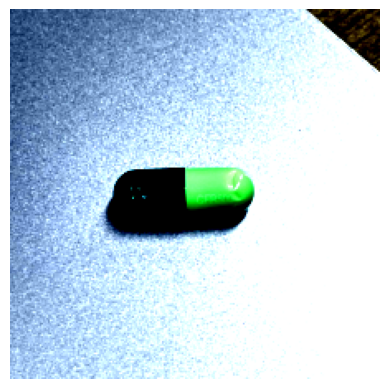

In [26]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load your trained PyTorch model
model = EnsembleModel(models).to(device)  # Replace YourModel() with your actual PyTorch model instance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define transformations to preprocess the image
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess your image
image = Image.open("/content/test5.jpeg")  # Replace "your_image.jpg" with the path to your image
image = preprocess(image).unsqueeze(0)

image = image.to(device)
# Put the model in evaluation mode
model.eval()

# Perform inference
with torch.no_grad():
    output = model(image)

_, predicted_class = torch.max(output, 1)

if predicted_class.item() == 0:
    print("이 알약은 덱스부정 입니다.")
elif predicted_class.item() == 1:
    print("이 알약은 록소닌정입니다.")
elif predicted_class.item() == 2:
    print("이 알약은 리노에바티스서방캡슐 입니다.")
elif predicted_class.item() == 3:
    print("이 알약은 모사핀정 입니다.")
elif predicted_class.item() == 4:
    print("이 알약은 미프론정 입니다.")
elif predicted_class.item() == 5:
    print("이 알약은 세파록실캡슐 입니다.")
elif predicted_class.item() == 6:
    print("이 알약은 소론도정 입니다.")
elif predicted_class.item() == 7:
    print("이 알약은 엑사드캡슐 입니다.")
elif predicted_class.item() == 8:
    print("이 알약은 영진브로멜라인장용정 입니다.")
elif predicted_class.item() == 9:
    print("이 알약은 코데닝정 입니다.")

plt.imshow(image.squeeze().permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()